### Site mean directions

#### Importing modules and function definitions

In [1]:
import pmagpy.pmag as pmag
import pmagpy.pmagplotlib as pmagplotlib
import pmagpy.ipmag as ipmag
import matplotlib.pyplot as plt # our plotting buddy
from pmagpy import convert_2_magic as convert
import numpy as np # the fabulous NumPy package
import pandas as pd # and of course Pandas
has_basemap, Basemap = pmag.import_basemap()
has_cartopy, Cartopy = pmag.import_cartopy()
from IPython.display import Image
%matplotlib inline 

In [2]:
#help(ipmag.fisher_mean)

In [3]:
#define a fisher_means function
def fisher_means(di_block,n, tc: bool):
    mode_1,mode_2=pmag.separate_directions(di_block) #mode_1,mode_2: 2 arrays of nested dec,inc pairs
    # Calculates the Fisher mean and associated parameters
    mode_1_fpars=ipmag.fisher_mean(di_block=mode_1)
    mode_2_fpars=ipmag.fisher_mean(di_block=mode_2)

    
    # Build a dataframe with fisher statistics of all modes and the overall mean
    mean_mode_1 = pd.DataFrame(mode_1_fpars, index =['Normal'])
    mean_mode_2 = pd.DataFrame(mode_2_fpars, index =['Reverse'])
    all_means = pd.concat([mean_mode_1, mean_mode_2])

 
    # Calculates the Fisher mean of all_to_single_mode directions.
    if mode_2.any():
        to_single_mode_2_dec=mode_2.transpose()[0]+180 # all_to_single mode: all directions shifted to one polarity
        to_single_mode_2_inc= - mode_2.transpose()[1]
        to_single_mode_2 = np.array([to_single_mode_2_dec,to_single_mode_2_inc]).transpose()
        all_to_single = np.concatenate((mode_1,to_single_mode_2))
        all_to_single_fpars =ipmag.fisher_mean(di_block=all_to_single)
        mean_all_to_single = pd.DataFrame(all_to_single_fpars, index =["all to normal"])
        all_means = pd.concat([all_means, mean_all_to_single])


    # arrange columns in dataframe
    cols = all_means.columns.tolist()
    cols = cols[2:3] + cols[:2] + cols[3:]
    all_means = all_means[cols]
    if tc == False:
        all_means = all_means.rename(columns = {cols[1]:'Dg', cols[2]:'Ig'})
    else:
        all_means = all_means.rename(columns = {cols[1]:'Ds', cols[2]:'Is'})
        
    # Check if mode_1 is Normal or Reversed polarity
    if all_means.iloc[0,1] >90 and all_means.iloc[0,1] <270:
        all_means = all_means.rename(index={'Normal': "Reverse", 'Reverse': "Normal"})
    
    all_means = all_means.round(2)
    
    # plot the data
    ipmag.plot_net(n)
    ipmag.plot_di(di_block=di_block,color='black',edge='white',markersize=30)
    # draw on the means and lpha95
    ipmag.plot_di_mean(dec=mode_1_fpars['dec'],inc=mode_1_fpars['inc'],a95=mode_1_fpars['alpha95'],\
                  marker='*',color='blue',markersize=50)
    if mode_2_fpars == {}:
        pass
    else:
        ipmag.plot_di_mean(dec=mode_2_fpars['dec'],inc=mode_2_fpars['inc'],a95=mode_2_fpars['alpha95'],\
                  marker='*',color='blue',markersize=50)
        ipmag.plot_di_mean(dec=all_to_single_fpars['dec'],inc=all_to_single_fpars['inc'],a95=all_to_single_fpars['alpha95'],\
                  marker='*',color='green',markersize=50)
    return all_means

### Reading input excel file

In [4]:
### Reading input excel file

#set path to data file. excel file with column headings as "site", "Dg", "Ig", "Ds", "Is"
#path not required if notebook located in the same folder"
path = 'SJF/'          #Give a path to folder from working directory
site_name = "SJF"       #Give a site name
file = path+'SJF_Dir.xlsx'

#reading input data file
xls = pd.ExcelFile(file)
datafile = xls.parse(0) #first sheet (0) of the excel file parsed to variable
datafile = datafile.set_index('sample')

In [5]:
## Quality of the dataset
N =len(datafile)-len(datafile[datafile["Q"]==4])
Q = [1,2,3,4]
n = [len(datafile[datafile["Q"]==1]),len(datafile[datafile["Q"]==2]),len(datafile[datafile["Q"]==3]),len(datafile[datafile["Q"]==4])]
p = [100*n[0]/N,100*n[1]/N,100*n[2]/N,'']                                                                                                   
quality = {"Quality": Q, "number": n, "percentage": p}
quality_df = pd.DataFrame.from_dict(quality).round(2)
quality_df = quality_df.set_index('Quality')
quality_df #show only Q 1 to 3 (ChRM directions. Quality 4 corresponds to secondary components

,number,percentage
Quality,,
1,65,34.946237
2,111,59.677419
3,10,5.376344
4,0,


### Select the Quality rank for the analysis

In [6]:
Qmin = str(input('Set Lower Quality (default¨Q = 2): '))
if not Qmin:
    Qmin = 2
Qmax = str(input('Set HIgher Quality (default Q¨= 1): '))
if not Qmax:
    Qmax = 1
print ('Directions of Quality from '+str(Qmin)+' to '+str(Qmax)+ ' selected')
Qmin = int(Qmin)
Qmax = int(Qmax)
Selecteddata = datafile[datafile['Q'].between(Qmax, Qmin, inclusive=True)]

Selecteddata
di_s =np.array([Selecteddata["Ds"], Selecteddata["Is"]]).transpose()
di_g =np.array([Selecteddata["Dg"], Selecteddata["Ig"]]).transpose()


Set Lower Quality (default¨Q = 2):  2
Set HIgher Quality (default Q¨= 1):  1


Directions of Quality from 2 to 1 selected


### Mean directions

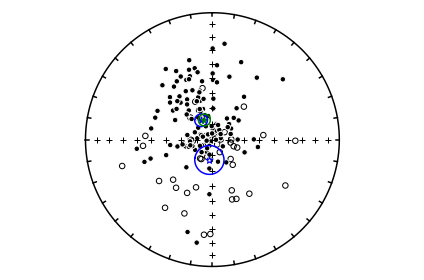

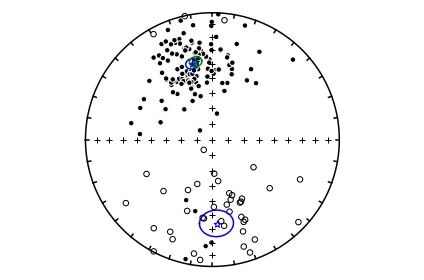

,n,Dg,Ig,r,k,alpha95,csd,n,Ds,Is,r,k,alpha95,csd
Normal,134,329.7,75.7,120.9,10.1,4.0,25.4,133,344.9,38.1,122.2,12.3,3.6,23.1
Reverse,42,188.4,-76.8,35.8,6.6,9.3,31.5,43,177.2,-34.0,36.1,6.1,9.6,32.7
all to normal,176,337.7,76.4,156.3,8.9,3.8,27.2,176,347.8,37.3,157.9,9.7,3.6,26.0


In [7]:
means_g = fisher_means(di_g,1, tc = False)
# saving plot to file
plt.savefig(path+site_name+'_stereplot_notc.pdf', dpi=None, facecolor='w', edgecolor='w', orientation='portrait', papertype=None, format='pdf',
        transparent=False, bbox_inches=None, pad_inches=0.1, frameon=None, metadata=None)
    
means_s = fisher_means(di_s,2, tc = True)
# saving plot to file
plt.savefig(path+site_name+'_stereplot_tc.pdf', dpi=None, facecolor='w', edgecolor='w', orientation='portrait', papertype=None, format='pdf',
        transparent=False, bbox_inches=None, pad_inches=0.1, frameon=None, metadata=None)

plt.show()

means = pd.concat([means_g,means_s], axis =1).round(1)
means

### Save excel file

In [ ]:
outputfile = path+site_name+"_means.xlsx"
export_file = ''
while export_file != "y" and export_file != "n":
    print('save and overwrite', path+site_name,"_means.xlsx?")
    export_file = str(input("(y/n)?:"))
    if export_file == 'y':
        means.to_excel(outputfile)
        print("file saved to ", path+site_name,"_means.xlsx")
    if export_file == "n":
        print("file with mean directions NOT saved")

save and overwrite SJF/SJF _means.xlsx?
